In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from models import Generator, Discriminator
from utils import get_noise, get_gradient_penalty, show_tensor_images

In [2]:
architecture = 'DCGAN' # DCGAN or WGAN-GP
conditional = True
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
device = 'cpu'

if architecture == 'DCGAN': 
    criterion = nn.BCEWithLogitsLoss()
    crit_repeats = 1
elif architecture == 'WGAN-GP':
    crit_repeats = 5

im_shape = (1, 28, 28)
n_classes = 10 if conditional else 0 # number of classes
im_chan = im_shape[0] # 1 for black and white

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [3]:

generator_input_dim = z_dim + n_classes
discriminator_im_chan = im_chan + n_classes

gen = Generator(generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Discriminator(discriminator_im_chan).to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

  7%|▋         | 31/469 [00:18<04:53,  1.49it/s]

Epoch 1, step 500: Generator loss: 2.252621764302254, critic loss: 0.20525893084704877


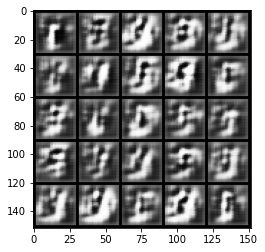

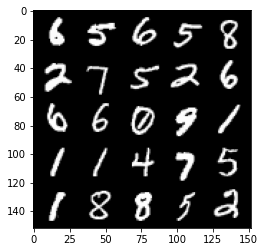

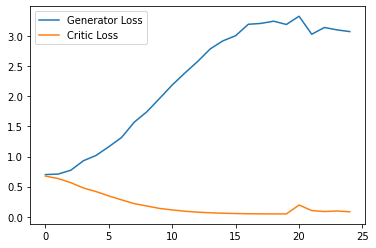

 13%|█▎        | 62/469 [00:34<04:11,  1.62it/s]

Epoch 2, step 1000: Generator loss: 1.5438367775678634, critic loss: 0.4287064881026745


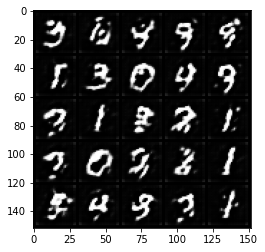

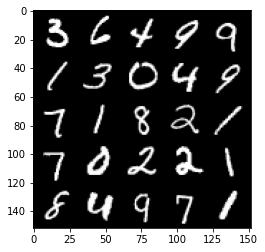

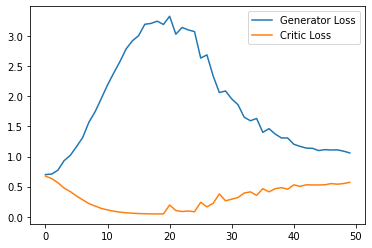

 20%|█▉        | 93/469 [00:51<03:23,  1.85it/s]

Epoch 3, step 1500: Generator loss: 1.0462163825035096, critic loss: 0.5635783680677414


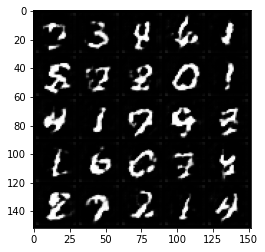

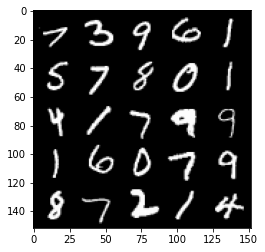

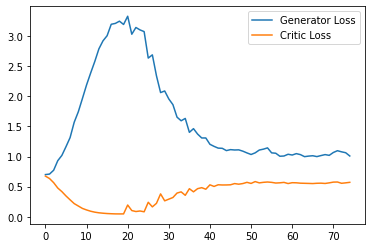

 26%|██▋       | 124/469 [01:09<03:07,  1.84it/s]

Epoch 4, step 2000: Generator loss: 1.0138226870298386, critic loss: 0.5619988976120949


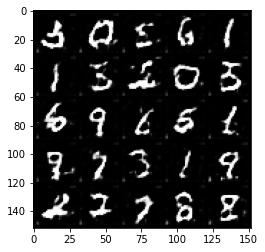

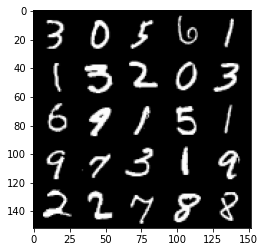

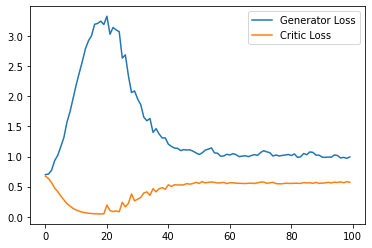

 33%|███▎      | 155/469 [01:26<02:51,  1.83it/s]

Epoch 5, step 2500: Generator loss: 0.9676179147958756, critic loss: 0.5916490852832794


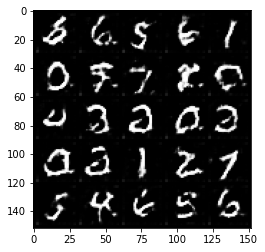

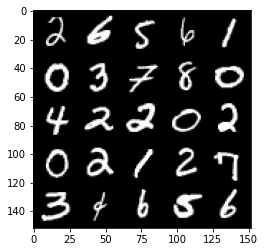

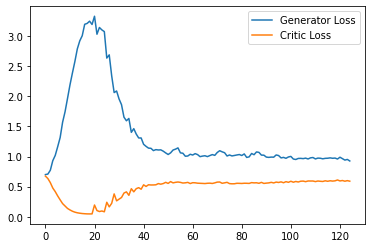

 40%|███▉      | 186/469 [01:43<02:37,  1.80it/s]

Epoch 6, step 3000: Generator loss: 0.9464364387989044, critic loss: 0.6049672837257385


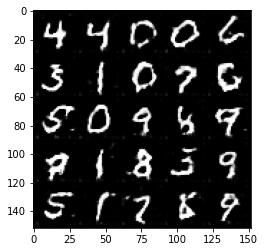

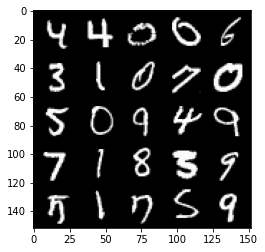

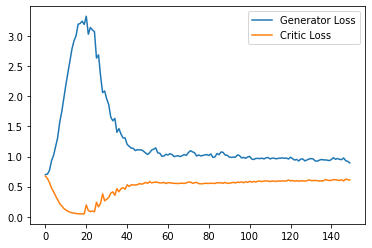

 46%|████▋     | 217/469 [03:30<06:04,  1.45s/it]

Epoch 7, step 3500: Generator loss: 0.9038248642683029, critic loss: 0.6183507953882217


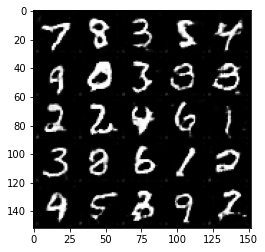

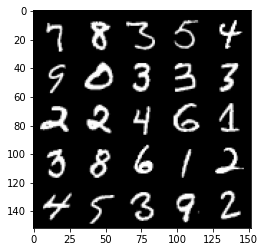

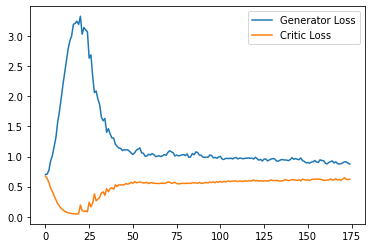

 35%|███▌      | 166/469 [03:20<06:05,  1.21s/it]


KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Format labels
        if conditional:
            one_hot_labels = nn.functional.one_hot(labels.to(device), n_classes)
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, im_shape[1], im_shape[2])

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic/discriminator ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            if conditional:
                noise_and_labels = torch.cat((fake_noise.float(), one_hot_labels.float()), dim=1)
                fake = gen(noise_and_labels)
                fake_image_and_labels = torch.cat((fake.detach().float(), image_one_hot_labels.float()), dim=1)
                real_image_and_labels = torch.cat((real.float(), image_one_hot_labels.float()), dim=1)
                crit_fake_pred = crit(fake_image_and_labels)
                crit_real_pred = crit(real_image_and_labels)
            else:
                fake = gen(fake_noise)
                crit_fake_pred = crit(fake.detach())
                crit_real_pred = crit(real)

            if architecture == 'DCGAN':
                crit_fake_loss = criterion(crit_fake_pred, torch.zeros_like(crit_fake_pred))
                crit_real_loss = criterion(crit_real_pred, torch.ones_like(crit_real_pred))
                crit_loss = (crit_fake_loss + crit_real_loss) / 2
            elif architecture == 'WGAN-GP':
                epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
                # gradient = get_gradient(crit, real, fake.detach(), epsilon)
                # gp = gradient_penalty(gradient)
                # crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
                gp = get_gradient_penalty(crit, real, fake.detach(), epsilon)
                crit_loss = torch.mean(crit_fake_pred - crit_real_pred) + c_lambda*gp

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        if conditional: # WHY DO NOT GENERATE AGAIN NEW FAKES?
            fake_image_and_labels = torch.cat((fake.float(), image_one_hot_labels.float()), dim=1)
            crit_fake_pred = crit(fake_image_and_labels)
        else:
            fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
            fake_2 = gen(fake_noise_2)
            crit_fake_pred = crit(fake_2)
        
        if architecture == 'DCGAN':
            gen_loss = criterion(crit_fake_pred, torch.ones_like(crit_fake_pred))
        elif architecture == 'WGAN-GP':
            # gen_loss = get_gen_loss(crit_fake_pred)
            gen_loss = -torch.mean(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
